In [1]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from sklearn.neighbors import KDTree
import sys
import math
import json

In [4]:
from util.Graph_and_Vertex_v1 import Graph
from util.Graph_and_Vertex_v1 import Vertex
import util.reader_v1 as reader
import heapq
import numpy

def shortest(v, path):
    ''' make shortest path from v.previous'''
    if v.previous:
        path.append(v.previous.getVertexID())
        shortest(v.previous, path)
    return

def dijkstra(G, source, destination):
    print('''Dijkstra's shortest path''')
    # Set the distance for the source node to zero
    source.setDistance(0)
    source.setDistance1(destination)

    # Put tuple pair into the priority queue
    # Put all vertex into the priority queue
    # for v in G:
    #     v.setDistance1(destination)

    unvisitedQueue = [(source.getDistance() + source.getDistance1(), source)]
    heapq.heapify(unvisitedQueue)

    for dist, v in unvisitedQueue:
        print([dist, v.id])

    while len(unvisitedQueue):
        # Pops a vertex with the smallest distance
        uv = heapq.heappop(unvisitedQueue)
        current = uv[1]
        current.setVisited()

        # for next in v.adjacent:
        for next in current.adjacent:
            # if visited, skip
            if next.visited:
                continue
            newDist = current.getDistance() + current.getWeight(next)

            if newDist < next.getDistance():
                next.setDistance(newDist)
                next.setPrevious(current)
                print('Updated : current = %s next = %s newDist = %s' \
                      % (current.getVertexID(), next.getVertexID(), next.getDistance()))
            else:
                print('Not updated : current = %s next = %s newDist = %s' \
                      % (current.getVertexID(), next.getVertexID(), next.getDistance()))

        # 因为节点的距离属性更新了 而队列中的距离属性没有更新 重新更新下队列
        unvisitedSet = set()   # set： 本次迭代中队列未出队的节点 + 本次迭代中出队节点的adj
        while len(unvisitedQueue):
            uv = heapq.heappop(unvisitedQueue)
            unvisitedSet.add(uv[1])
        unvisitedSet.update({adjV for adjV in current.adjacent if not adjV.visited})

        # #查看下次迭代入队节点的情况
        # print('下轮迭代，入队节点:', end=' ')
        # for i in unvisitedSet:
        #     print(i.id, end=' ')
        # print()

        for v in unvisitedSet:
            v.setDistance1(destination)

        unvisitedQueue = [(v.getDistance() + v.getDistance1(), v) for v in unvisitedSet]
        heapq.heapify(unvisitedQueue)


        for dist, v in unvisitedQueue:
            print([dist, v.id])
        # break
G = reader.read_data_piece("./data/dijkstra_A.csv")
# g_json = G.toJson()
# a = json.loads(g_json)
# #print(type(a))  # list
# del G
# G = reader.read_json(a)

In [5]:
print(G.getLocIdMap())

{(2.0, 4.0): '0', (2.0, 1.0): '1', (4.0, 4.0): '2', (3.0, 6.0): '3', (3.0, 8.0): '4', (3.0, 3.0): '5', (1.0, 8.0): '7', (6.0, 1.0): '14', (4.0, 6.0): '6', (6.0, 4.0): '12', (6.0, 2.0): '13', (4.0, 10.0): '8', (5.0, 8.0): '9', (8.0, 10.0): '15', (6.0, 7.0): '10', (8.0, 8.0): '16', (6.0, 5.0): '11', (10.0, 3.0): '18', (9.0, 1.0): '17', (10.0, 6.0): '19'}


In [10]:
def getDistance_long_lat(real_point, node_point):
    lng1, lat1, lng2, lat2 = real_point[0], real_point[1], node_point[0], node_point[1]
    # dx = lng1 - lng2
    # dy = lat1 - lat2
    # b = (lat1 + lat2) / 2.0
    # Lx = math.radians(dx) * 6367000.0 * math.cos(math.radians(b))
    # Ly = 6367000.0 * math.radians(dy)
    Lx = float(lng1)-float(lng2)
    Ly = float(lat1)-float(lat2)
    return math.sqrt(Lx * Lx + Ly * Ly)

In [25]:
def findNearestNode(loc_id_map,source_point,destination_point):
    '''
    args： loc2idmap   ：     map  {key：(顶点的经纬度)，value(vert的id)}   like {(2.0, 4.0): '0', (2.0, 1.0): '1'}
           source_point:      list [起始点的经纬度]
           destination_point：list [目的地的经纬度] 
    用途： 查找最近邻的n个点并返回以及距离
    return：list[list]:  排序后的 [['0', 8.48528137423857], ['3', 8.639192214932638]] 
    '''
    #print(loc2idmap)
    points = np.array(list(loc_id_map.keys()))
    #print(points)# [[ 2.  4.] [ 2.  1.]]
    tree = KDTree(points)
    
    # kNN 按个数找最近的4个候选点
    dists, indices = tree.query([source_point], k=4)
    # print(dists, indices) # [[0.         1.41421356  2.         2.23606798]] [[0 5 2 3]]
    
    
    
    #计算候选点的A*距离
    candi_list = []
    
    for i, index in enumerate(indices[0]):
        candi_vertex_id = loc_id_map[tuple(points[index])]  # 候选点id
        candi_vertex = G.getVertex(candi_vertex_id)   # 候选
        
#         ## print(candi_vertex_id,candi_vertex)
#         print("顶点",candi_vertex_id, "位置: ", candi_vertex.get_lat_long(),  end = " 距离：")         # loc_id_map[float(v.long), float(v.lat)] = v.id
#         ##print(candi_vertex.get_lat_long())
#         print("出发点：" ,  str(getDistance_lat_long( source_point , candi_vertex.get_lat_long()))       )
#         print("结束点：" ,  str(getDistance_lat_long( destination_point , candi_vertex.get_lat_long()))   )

#         dist2source      = getDistance_lat_long( source_point      , candi_vertex.get_lat_long()) # 到出发点的距离
        dist2source = dists[0][i]
        dist2destination = getDistance_long_lat( destination_point , candi_vertex.get_long_lat()) # 到目的点的距离
        distsum = 1* dist2source + 0.5*dist2destination
        candi_list.append([candi_vertex_id,distsum,dist2source])
        
    candi_list = sorted(candi_list,  key=lambda x: x[1])
    return candi_list 

In [34]:
source_point=[3,2]
destination_point=[9,6]

In [35]:
source_candi_list = findNearestNode(G.getLocIdMap(),source_point,destination_point)
# print(candi_list)
source_vertex_id = source_candi_list[0][0]
print('出发点 %s'%(source_vertex_id))

出发点 5


In [37]:
destination_candi_list = findNearestNode(G.getLocIdMap(),destination_point,source_point)
# print(candi_list)
destination_vertex_id = destination_candi_list[0][0]
print('终止点 %s'%(destination_vertex_id))

终止点 19


In [38]:
G.reset()
source = G.getVertex(source_vertex_id)
destination = G.getVertex(destination_vertex_id)
dijkstra(G, source, destination) 
# for i in source.getConnections():
#     print(i.id)

Dijkstra's shortest path
[7.615773105863909, '5']
Updated : current = 5 next = 1 newDist = 2.5
Updated : current = 5 next = 2 newDist = 1.5
[7.824555320336759, '2']
[11.933981132056603, '1']
Updated : current = 2 next = 0 newDist = 3.5
Updated : current = 2 next = 6 newDist = 3.5
Updated : current = 2 next = 12 newDist = 3.5
Updated : current = 2 next = 13 newDist = 4.5
[7.97213595499958, '12']
[9.5, '6']
[10.15685424949238, '13']
[11.746211251235321, '0']
[11.933981132056603, '1']
Updated : current = 12 next = 11 newDist = 4.5
Not updated : current = 12 next = 13 newDist = 4.5
[8.623105625617661, '11']
[9.5, '6']
[11.746211251235321, '0']
[10.15685424949238, '13']
[11.933981132056603, '1']
Updated : current = 11 next = 16 newDist = 8.5
[9.5, '6']
[10.15685424949238, '13']
[11.746211251235321, '0']
[11.32842712474619, '16']
[11.933981132056603, '1']
Updated : current = 6 next = 3 newDist = 4.5
Updated : current = 6 next = 9 newDist = 6.0
[10.15685424949238, '13']
[11.32842712474619, '1

In [39]:
for v in G.vertDictionary.values():
    print(source.getVertexID(), " to ", v.getVertexID(), "-->", v.getDistance())

path = [destination.getVertexID()]
shortest(destination, path)
print ('The shortest path  is:    %s'    % (path[::-1]))
print ('The shortest distance is: %s' %    (destination.distance))

5  to  0 --> 3.5
5  to  1 --> 2.5
5  to  2 --> 1.5
5  to  3 --> 4.5
5  to  4 --> 6.5
5  to  5 --> 0
5  to  7 --> 10.5
5  to  14 --> 5.5
5  to  6 --> 3.5
5  to  12 --> 3.5
5  to  13 --> 4.5
5  to  8 --> 9.0
5  to  9 --> 6.0
5  to  15 --> 10.5
5  to  10 --> 7.5
5  to  16 --> 8.5
5  to  11 --> 4.5
5  to  18 --> 9.0
5  to  17 --> 8.5
5  to  19 --> 12.0
The shortest path  is:    ['5', '2', '13', '18', '19']
The shortest distance is: 12.0


[[2.         2.         2.23606798 2.23606798]] [[ 7  1  5 10]]
[['13', 6.35917360311745], ['14', 6.47213595499958], ['5', 9.23606797749979], ['1', 10.246211251235321]]
[array([ 0,  1,  2,  5,  7,  9, 10], dtype=int64)]


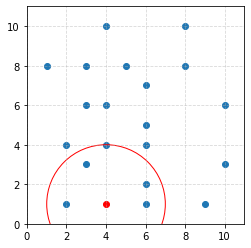

In [22]:
locidmap = G.getLocIdMap()
#print(locidmap)
points = np.array(list(locidmap.keys()))
#print(points)# [[ 2.  4.] [ 2.  1.]]
tree = KDTree(points)



# kNN 按个数找
dists, indices = tree.query([source_point], k=4)
print(dists, indices)
min_dist = [sys.maxsize,-1]
candi_list = []
for i in indices[0]:
    candi_vertex_id = locidmap[tuple(points[i])]  # 候选点id
    candi_vertex = G.getVertex(candi_vertex_id)   # 候选点
#    ## print(candi_vertex_id,candi_vertex)
#     print("顶点",candi_vertex_id, "位置: ", candi_vertex.get_lat_long(),  end = " 距离：")         # loc2idmap[float(v.long), float(v.lat)] = v.id
#     ##print(candi_vertex.get_lat_long())
#     print("出发点：" ,  str(getDistance_lat_long( source_point , candi_vertex.get_lat_long()))       )
#     print("结束点：" ,  str(getDistance_lat_long( destination_point , candi_vertex.get_lat_long()))   )


    dist2source      = getDistance_lat_long( source_point      , candi_vertex.get_long_lat()) # 到出发点的距离
    dist2destination = getDistance_lat_long( destination_point , candi_vertex.get_long_lat()) # 到目的点的距离
    distsum = 1* dist2source+1*dist2destination
    candi_list.append([candi_vertex_id,distsum])
    
candi_list = sorted(candi_list,  key=lambda x: x[1])
    
print(candi_list)

# 按范围找
indices = tree.query_radius([source_point], r=4)
print(indices)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.add_patch(Circle(source_point, 3, color='r', fill=False))
X, Y = [p[0] for p in points], [p[1] for p in points]
plt.grid(True, linestyle="--", alpha=0.5)   # 网格
plt.xlim(xmin=0,xmax=11)
plt.ylim(ymin=0,ymax=11)
plt.scatter(X, Y)
plt.scatter([source_point[0]], [source_point[1]], c='r')
plt.show()

In [23]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
# import numpy as np
# from matplotlib import pyplot as plt
# from matplotlib.patches import Circle
# from sklearn.neighbors import KDTree

# np.random.seed(0)
# points = np.random.random((100, 2))
# tree = KDTree(points)
# point = points[0]

# # kNN
# dists, indices = tree.query([point], k=3)
# print(dists, indices)

# # query radius
# indices = tree.query_radius([point], r=0.2)
# print(indices)

# fig = plt.figure()
# ax = fig.add_subplot(111, aspect='equal')
# ax.add_patch(Circle(point, 0.2, color='r', fill=False))
# X, Y = [p[0] for p in points], [p[1] for p in points]
# plt.scatter(X, Y)
# plt.scatter([point[0]], [point[1]], c='r')
# plt.show()